# Analysis of local search behavior after reward in single-object forest
### For experiments with multiple conditions tested (not in single fly). First part of notebook to copare acorss flies within single condition (e.g. with or without LMs), second part to compare across conditions.
* Assumes use of FlyOver version 1.0.7 or higher (closed-loop optogenetic stimulation *with reset radius*)
* Data from multiple trials and flies is pooled and collected in a single data frame, which is then used for data visualisation and statistics.

In [1]:
import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk, getcwd
from os.path import isfile, sep, exists
from sys import path, exit
from glob import glob
from operator import itemgetter

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
from matplotlib import gridspec
import seaborn as sns

from scipy import stats as sts

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# Set path to analysis code directory
codeDir = sep.join(getcwd().split(sep)[:-2])
path.insert(1, codeDir)

from flyVR.flyVRoptogenetics.flyVRoptogenetics_oneTrialBasicAnalysis import singleVROptoPulseTrialAnalysis
from flyVR.utilities.loadObjectCoords import loadObjectCoords

from plottingUtilities.basicPlotting import myAxisTheme,_myAccentList
from plottingUtilities.objectInteractionPlots import plotWalkingVelocityDistrSimple, oneDimResidencyWithVar_df
from plottingUtilities.objectPreferencePlots import countvisits, diffCorrPlot, prettyBoxPlot, simpleBoxPlot

In [2]:
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

## (1) Analysis of single condition
### Select rawData folder

In [815]:
# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObjOpt/localSearch/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
expDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
root.update()
root.destroy()

FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
FODataFiles = sorted(FODataFiles)

print('\n Analysing the following {} log files:\n'.format(len(FODataFiles)))
for FOfile in FODataFiles:
    print(FOfile) 


 Analysing the following 20 log files:

singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f01_24h_9d_180909170029.txt
singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f02_25h_9d_180909172526.txt
singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f03_26h_9d_180909184521.txt
singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f04_24h_10d_180910163546.txt
singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f05_24h_6-9d_180910170356.txt
singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f06_26h_6-9d_180910184052.txt
singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f07_24h_7-10d_180911161226.txt
singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f08_24h_7-10d_180911163951.txt
singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f09_25h_7-10d_180911175603.txt
singleObjectForest_visLM_1cm4cmCone_12cmHex_G

In [816]:
dataDir = sep.join(expDir.split(sep)[0:-2]) + sep

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    mkdir(analysisDir)
except OSError:
    print('Analysis directory already exists.')
    
rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
                               'instead of loading previously saved data? (y, n)\n')

Analysis directory already exists.
Would you like to (re-)run the basic analysis on each file 
instead of loading previously saved data? (y, n)



In [817]:
FODataFiles = FODataFiles[:]
# Uncomment, if you want to select a specific subset of flies (e.g. good learners..)
#my_indices = [2, 3, 4, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 29]
#FODataFiles = itemgetter(*my_indices)(expDirs)

selectionTag = ''#'_min3visitsEachPre'  # chose small string, to specify dataset (e.g. top5 flies)
FODataFiles

['singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f01_24h_9d_180909170029.txt',
 'singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f02_25h_9d_180909172526.txt',
 'singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f03_26h_9d_180909184521.txt',
 'singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f04_24h_10d_180910163546.txt',
 'singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f05_24h_6-9d_180910170356.txt',
 'singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f06_26h_6-9d_180910184052.txt',
 'singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f07_24h_7-10d_180911161226.txt',
 'singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f08_24h_7-10d_180911163951.txt',
 'singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f09_25h_7-10d_180911175603.txt',
 'singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64

### Compose mutli-fly data into dataframe

In [818]:
# generate fly color map
numFlies = len(FODataFiles)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)

mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

In [819]:
genotype = dataDir.split(sep)[-5][:-2]
protocol = dataDir.split(sep)[-2]
print(genotype)
print(protocol)

hexGridSize = int(dataDir.split(sep)[-4][:2])*10
print(hexGridSize)

Gr64f_x_10xChrimsonR
visLM
120


In [820]:
keylist = ['headingAngle','rotVelo','time','transVelo',
           'xPos','xPosInMiniarena','yPos','yPosInMiniarena','rEvents']

keylistLong = ['flyID','trial','trialtype','reinforcement','protocol','moving'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)
 
vTransTH = 2 #mm/s

# Run single trial analysis on each file in folder .....................................................
for fileToAnalyse in FODataFiles:
    print('\n Analysing the following log file:\n')
    print(fileToAnalyse)

    flyID = fileToAnalyse.split('_')[-4]
    starvation = fileToAnalyse.split('_')[-3]

    trial = FODataFiles.index(fileToAnalyse) + 1

    if rerunbasicanalysis == 'y':
        returnVal = singleVROptoPulseTrialAnalysis(expDir, fileToAnalyse, hexGridSize)
        print('Ran analysis, now loading saved *.npy file.')
        FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
    else:
        print('Loading saved *.npy file.')
        FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]

    # Split into visible object trials and invisible object trials
    if 'train' in fileToAnalyse:
        trialtype = 'train'
        rZones = 'on'
    elif 'pre' in fileToAnalyse:
        trialtype = 'pre'
        rZones = 'off'
    else:
        trialtype = 'post'
        rZones = 'off'

    vTrans = np.copy(FODatLoad['transVelo'])
    moving = vTrans >= vTransTH

    FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
    FODatLoad_df.insert(0, 'flyID', flyID)
    FODatLoad_df.insert(1, 'trial', trial)
    FODatLoad_df.insert(2, 'trialtype', trialtype)
    FODatLoad_df.insert(3, 'reinforcement', rZones)
    FODatLoad_df.insert(4, 'protocol', protocol)
    FODatLoad_df.insert(5, 'moving', moving)

    FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)


 Analysing the following log file:

singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f01_24h_9d_180909170029.txt
Loading saved *.npy file.

 Analysing the following log file:

singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f02_25h_9d_180909172526.txt
Loading saved *.npy file.

 Analysing the following log file:

singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f03_26h_9d_180909184521.txt
Loading saved *.npy file.

 Analysing the following log file:

singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f04_24h_10d_180910163546.txt
Loading saved *.npy file.

 Analysing the following log file:

singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f05_24h_6-9d_180910170356.txt
Loading saved *.npy file.

 Analysing the following log file:

singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f06_26h_6-9d_180910184052.txt
Loading saved *.npy file.

 Analysing the f

In [821]:
FOAllFlies_df = FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')
FOAllFlies_df['reinforcement'] = FOAllFlies_df['reinforcement'].astype('category')

FOAllFlies_df.head()

,flyID,trial,trialtype,reinforcement,protocol,moving,headingAngle,rotVelo,time,transVelo,xPos,xPosInMiniarena,yPos,yPosInMiniarena,rEvents
0,f01,1.0,post,off,visLM,1.0,-0.000004,1.087098,0.000000,17.761374,60.622000,NaN,35.000000,NaN,0.0
1,f01,1.0,post,off,visLM,1.0,0.054353,1.304424,0.050002,8.490858,61.499344,NaN,34.862218,NaN,0.0
2,f01,1.0,post,off,visLM,1.0,0.119576,1.413144,0.100003,7.494538,61.923075,NaN,34.835742,NaN,0.0
3,f01,1.0,post,off,visLM,1.0,0.190236,1.304417,0.150005,4.026785,62.289100,NaN,34.755400,NaN,0.0
4,f01,1.0,post,off,visLM,1.0,0.255459,1.087026,0.200006,8.447349,62.428298,NaN,34.609922,NaN,0.0


In [822]:
flyIDallarray = np.asarray(FOAllFlies_df['flyID'].values).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))
%matplotlib inline

### Define structure of trials in terms of closed-loop optogenetic stimulation and presence of landmark cues

In [823]:
# Two object reinforcement test
trialName = ['search']
gridSize = hexGridSize

rewardRad = 10 # mm
visitRad = 15

if 'noLM' in protocol or 'invLM' in protocol:
    visibility = 'invisible'
    condCol = ['grey']
    evLevel = 90
    
elif 'onlyLM' in protocol:
    visibility = 'visible'
    condCol = ['cornflowerblue']
    evLevel = 0.5
else:
    visibility = 'visible'
    condCol = ['slateblue']
    evLevel = 90

if gridSize == 240:
    if visibility == 'invisible':
        coordFile = 'singleObjectForest_rZones_invisible1cm4cmCone_{}cmHex.coords'.format(int(gridSize/10))
    else:
        coordFile = 'singleObjectForest_rZones_1cm4cmCone_{}cmHex.coords'.format(int(gridSize/10))
else:
    if visibility == 'invisible':
        coordFile = 'singleObjectForest_rZones_1cm4cmInvisibleCone_{}cmHex_large.coords'.format(int(gridSize/10))
    else:
        coordFile = 'singleObjectForest_rZones_1cm4cmCone_{}cmHex_large.coords'.format(int(gridSize/10))
fps = 20.0 # after downsampling

coneColor = 'mediumseagreen'
cyliColor = 'mediumorchid'
LMcols = [coneColor]

LMnames = ['Cone']
nLMtypes = len(LMnames)

visitRad = 15
# Use 15 mm as standard visit radius with two-landmark forest world, where
# LM are at least 60 mm separated.

LMcoords = (0,0)
# if reward around LM:
rewardCenter = LMcoords

# Time window for plots
windowMax = 20

In [824]:
visibleObjectCoords, invisibleObjectCoords, origin = loadObjectCoords(dataDir, coordFile)
if visibility == 'invisible':
    objcoord = invisibleObjectCoords
else:
    objcoord = visibleObjectCoords

## Velocity distributions

In [825]:
histRangeVT = (vTransTH, 35)
histRangeVR = (-8,8)
numBins = 31

#### Compare velocity distribution before and after

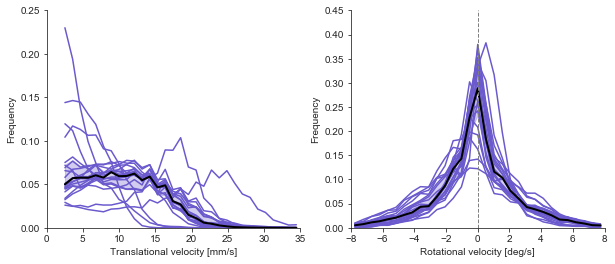

In [826]:
walkingFig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs = plotWalkingVelocityDistrSimple(axs, FOAllFlies_df,'moving>0', histRangeVT, histRangeVR,numBins, 
                                            flyIDs, condCol[0])
axs[0].set_ylim(0, 0.25)
axs[1].set_ylim(0, 0.45)
walkingFig.savefig(analysisDir + sep + 'velocityTraces' + sep + genotype + '_walkingVelocities_'+protocol+\
                   '_medianIQR_n'+str(numFlies) +selectionTag+'.pdf', format = 'pdf')

## Find encounters with virtual food

In [827]:
firsEncts = np.zeros((numFlies,2))
for fly in range(numFlies):
    querystring = '(flyID =="' + flyIDs[fly] +  '")'

    ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    time = FOAllFlies_df.query(querystring)['time'].values.squeeze()
    
    try:
        firstEncounter = int(np.where(ev > evLevel)[0][0])
        firsEncts[fly,:] = (firstEncounter, time[firstEncounter])
    except:
        firsEncts[fly,:] = (np.nan, np.nan)

Plot directory already exists


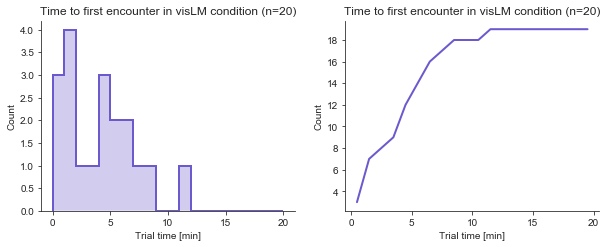

In [828]:
numBins=20
binRange = (0, 20)

hist, bin_edges = np.histogram(firsEncts[:,1][~np.isnan(firsEncts[:,1])]/60., bins=numBins, range=binRange, density=False)

binEds = bin_edges[:-1]+np.diff(bin_edges[:2])/2


encounterHistFig, axs = plt.subplots(1,2,figsize=(10,3.5))
axs[0].hist(firsEncts[:,1][~np.isnan(firsEncts[:,1])]/60., bins=numBins, range=binRange,
            color=condCol[0], linewidth=2, histtype='stepfilled', alpha=0.3, label='{}'.format(protocol))
axs[0].hist(firsEncts[:,1][~np.isnan(firsEncts[:,1])]/60., bins=numBins, range=binRange,
            color=condCol[0], linewidth=2, histtype='step', label='{}'.format(protocol))
axs[1].plot(binEds,np.cumsum(hist*np.diff(bin_edges)), color=condCol[0], linewidth=2, label='{}'.format(protocol))

for ax in axs:
    myAxisTheme(ax)
    ax.set_xlabel('Trial time [min]')
    ax.set_ylabel('Count')
    ax.set_title('Time to first encounter in {} condition (n={})'.format(protocol, numFlies))

try:
    mkdir(analysisDir + 'firstEncounter/')
except:
    print('Plot directory already exists')
encounterHistFig.savefig(analysisDir + 'firstEncounter/'+ genotype +'_'+flyIDs[0][0] +'_'+ protocol
                   +'_firstEncounterTimeHist_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf', transparent=True)

## Trajectory before and after first food encounter

In [829]:
# plot LM in "miniarena plot"
def plotSingleLMMiniArena(ax, gridSize, visibility):
    ax.axis('off')
    ax.set_aspect('equal')
    ax.set_xlim(-gridSize/2 - 5, gridSize/2 + 5)
    ax.set_ylim(-gridSize/2 - 5, gridSize/2 + 5)
    
    if visibility == 'invisible':
        ax.plot(0,0, marker='o', alpha=0.75, markeredgewidth=0.5, markerfacecolor='None', markeredgecolor='black')
    else:
        ax.plot(0,0, marker='o', alpha=0.75, markeredgewidth=0.5, markerfacecolor='black', markeredgecolor='black')

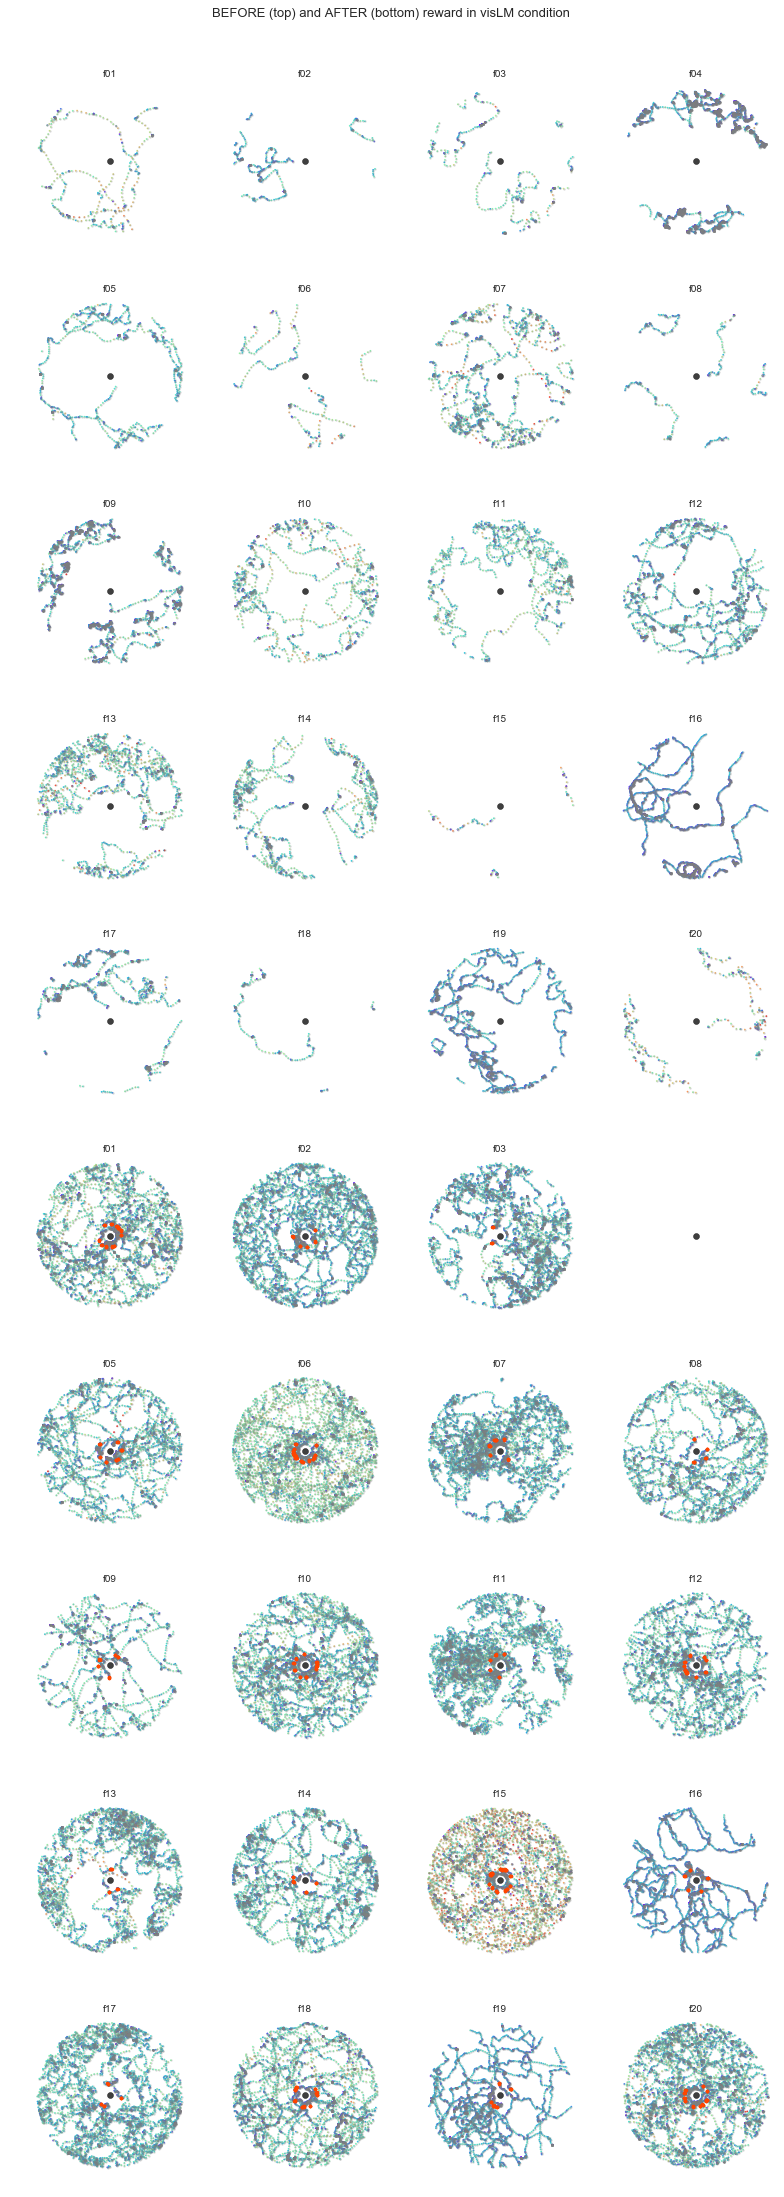

In [830]:
nrows = np.ceil((2*numFlies)/4.0)
ptsOmit = 3 # scale how many time points are plotted

allFlyTraceFig = plt.figure(figsize=(11,3*nrows))
figtitle = allFlyTraceFig.suptitle('BEFORE (top) and AFTER (bottom) reward in {} condition '.format(protocol),
                        fontsize=13,y=1.02)

for fly in range(numFlies):
    querystring = '(flyID =="' + flyIDs[fly] +  '")'

    perFlyX = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
    perFlyY = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
    perFlyEv = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    perFlyvT = FOAllFlies_df.query(querystring)['transVelo'].values.squeeze()
    
    # Before
    ax = allFlyTraceFig.add_subplot(nrows,4,fly+1)
    if np.isnan(firsEncts[fly,0]):
        selectPts = range(0,len(perFlyX),ptsOmit)
    else:
        selectPts = range(0,int(firsEncts[fly,0]),ptsOmit)
        
    ax.plot(perFlyX[selectPts],perFlyY[selectPts],'.',markersize=3,color='grey',alpha=0.2)
    ax.scatter(perFlyX[selectPts],perFlyY[selectPts],s=3, c=perFlyvT[selectPts], cmap='rainbow',
                                    vmin=-1, vmax=35, edgecolor='none',alpha=0.9)

    plotSingleLMMiniArena(ax, gridSize, visibility)
    ax.set_title(flyIDs[fly],fontsize=10)
    
    # After
    ax = allFlyTraceFig.add_subplot(nrows,4,fly+1 + numFlies)
    if np.isnan(firsEncts[fly,0]):
        plotSingleLMMiniArena(ax, gridSize, visibility)
    else:
        selectPts = range(int(firsEncts[fly,0]), len(perFlyX), ptsOmit)
        
        ax.plot(perFlyX[selectPts],perFlyY[selectPts],'.',markersize=3,color='grey',alpha=0.2)
        ax.scatter(perFlyX[selectPts],perFlyY[selectPts],s=3, c=perFlyvT[selectPts], cmap='rainbow',
                                        vmin=-1, vmax=35, edgecolor='none',alpha=0.9)

        ax.plot(perFlyX[perFlyEv>90],perFlyY[perFlyEv>90],'.',markersize=5,color='orangered',alpha=1)
        plotSingleLMMiniArena(ax, gridSize, visibility)
        ax.set_title(flyIDs[fly],fontsize=10)


allFlyTraceFig.tight_layout()

allFlyTraceFig.savefig(analysisDir +'tracePlotMA/'+ genotype +'_'+flyIDs[0][0] +'_'+ protocol
                          +'_traceBeforeAndAfter_n'+ str(len(flyIDs))+selectionTag+'.pdf', format='pdf', 
                          bbox_extra_artists=(figtitle,), bbox_inches='tight', transparent=True)

## Residency

### 2D (cartesian) residency in shifted space

Plot directory already exists


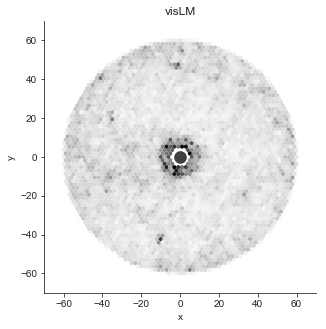

In [831]:
# plot parameter
numBins = hexGridSize/2

hexplotfig, ax = plt.subplots(1,1,figsize=(5*hexGridSize/120,5*hexGridSize/120))

querystring = '(moving > 0)'
xPosMA = np.asarray(FOAllFlies_df.query(querystring)['xPosInMiniarena']).squeeze()
yPosMA = np.asarray(FOAllFlies_df.query(querystring)['yPosInMiniarena']).squeeze()

ax.hexbin(xPosMA, yPosMA, gridsize=numBins, cmap='Greys',linewidths=0,vmin=0)
ax.set_xlabel('x')
ax.set_ylabel('y')
if visibility == 'invisible':
    ax.plot(LMcoords[0], LMcoords[1], marker='o', markersize=12, alpha=0.75, markeredgewidth=0.5,
                    markerfacecolor='None', markeredgecolor='black')
else:
    ax.plot(LMcoords[0], LMcoords[1], marker='o', markersize=12, alpha=0.75, markeredgewidth=0.5,
                    markerfacecolor='black', markeredgecolor='black')
ax.set_title(protocol)
ax.set_xlim(-gridSize/2-10,gridSize/2+10)
ax.set_ylim(-gridSize/2-10,gridSize/2+10)
ax.set_aspect('equal')
myAxisTheme(ax)

try:
    mkdir(analysisDir + 'residencyPlots/')
except:
    print('Plot directory already exists')
hexplotfig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0] +'_'+ protocol
                   +'_residencyMA_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf', transparent=True)

### 1D radial residency close around objects

In [832]:
resdf_keylist_short = ['flyID','reinforcement','moving','time']
resdf_keylist = resdf_keylist_short + ['dist2LM', 'condition']

residency_df = pd.DataFrame(data=np.zeros((0,len(resdf_keylist))), columns=resdf_keylist)
for fly in range(len(flyIDs)):
    querystring = '(flyID == "'+flyIDs[fly]+'")'
    xtrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
    ytrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()

    # compute distance to closest landmark for each type
    dist2LM = np.hypot((xtrial-LMcoords[0]),(ytrial-LMcoords[1]))
    tmpdf = FOAllFlies_df.query(querystring)[resdf_keylist_short]
    tmpdf.insert(1,'dist2LM', dist2LM)
    tmpdf.insert(1,'condition', protocol)

    residency_df = residency_df.append(tmpdf)

residency_df = residency_df[resdf_keylist]

In [833]:
movementFilter = 'moving > 0'
histRange = (5,hexGridSize/2)
numBins = 25* hexGridSize/120
varStyle = 'iqr' #'std'
lineAlpha = 1

condLegend = [protocol]

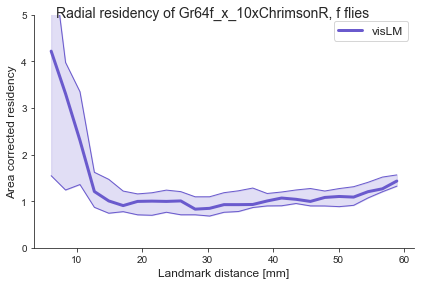

In [834]:
# linear residency around landmarks
radResFig, ax = plt.subplots(1,1,figsize=(6,4))
ax = oneDimResidencyWithVar_df(ax, residency_df, flyIDs, movementFilter, numBins, histRange, lineAlpha, 0, 
                               varStyle, 1, condCol, condLegend)

myAxisTheme(ax)
ax.set_ylim(0, 5)
radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)
radResFig.tight_layout()

radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0] +'_'+ protocol+'_radialResidencyVar_'
                   +varStyle+'_lin_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf', transparent=True)

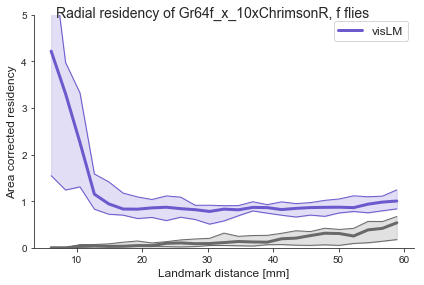

In [835]:
# linear residency around landmarks split into "BEFORE" and "AFTER" first reward encounter

radResFig, ax = plt.subplots(1,1,figsize=(6,4))
cols = [['dimgrey'], condCol]#[['thistle'], condCol]
for i, cond in enumerate(['Before', 'After']):
    residency_df = pd.DataFrame(data=np.zeros((0,len(resdf_keylist))), columns=resdf_keylist)
    for fly in range(len(flyIDs)):
        querystring = '(flyID == "'+flyIDs[fly]+'")'
        xtrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        ytrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()

        # compute distance to landmark
        if cond=='Before':
            if np.isnan(firsEncts[fly,0]):                
                dist2LM = np.hypot((xtrial-LMcoords[0]),(ytrial-LMcoords[1]))
                tmpdf = FOAllFlies_df.query(querystring)[resdf_keylist_short]
            else:
                enc = int(firsEncts[fly,0])
                dist2LM = np.hypot((xtrial[0:enc]-LMcoords[0]),(ytrial[0:enc]-LMcoords[1]))
                tmpdf = FOAllFlies_df.query(querystring)[resdf_keylist_short][0:enc] 
            tmpdf.insert(1,'dist2LM', dist2LM)
            tmpdf.insert(1,'condition', protocol)

            residency_df = residency_df.append(tmpdf)
        
        else:
            if not np.isnan(firsEncts[fly,0]): 
                enc = int(firsEncts[fly,0])
                dist2LM = np.hypot((xtrial[enc:]-LMcoords[0]),(ytrial[enc:]-LMcoords[1]))
                tmpdf = FOAllFlies_df.query(querystring)[resdf_keylist_short][enc:]
                tmpdf.insert(1,'dist2LM', dist2LM)
                tmpdf.insert(1,'condition', protocol)

                residency_df = residency_df.append(tmpdf)

    residency_df = residency_df[resdf_keylist]

    ax = oneDimResidencyWithVar_df(ax, residency_df, flyIDs, movementFilter, numBins, histRange, lineAlpha, 0, 
                                   varStyle, 1, cols[i], condLegend)
myAxisTheme(ax)
ax.set_ylim(0, 5)
radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)
radResFig.tight_layout()

radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0] +'_'+ protocol+
                  '_radialResidencyBeforeAfter_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf', transparent=True)

## Distribution of inter-reward intervals and inter-entry intervals

In [836]:
try:
    mkdir(analysisDir + 'interVisitInterval/')
except:
    print('Plot directory already exists')

Plot directory already exists


In [837]:
minutesRange = 5
binRange = (0,minutesRange*60) # start at 1 to exclude counting one reward even twice
numBins = minutesRange*6

In [838]:
# reward-based analysis
flyRewardStTimeDistr = np.nan*np.ones((numFlies,numBins))
allInterEntryTimes = []
numRewards = np.zeros((numFlies))

# visit-based analysis
flyEntryTimeDistr = np.nan*np.ones((numFlies,numBins))
allRewardTimes = []
numEntries = np.zeros((numFlies))

for fly in range(numFlies):
    querystring = 'flyID == "'+flyIDs[fly]+'"'
    xtrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
    ytrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
    ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    time = FOAllFlies_df.query(querystring)['time'].values.squeeze()

    # compute distance to closest reward center
    dist2LM = np.hypot((xtrial-rewardCenter[0]),(ytrial-rewardCenter[1]))
    entries,exits,visitT,entryTime,exitTime = countvisits(dist2LM,time,visitRad)
    
    if type(entryTime) is float:
        numEntries[fly] = 0
        flyEntryTimeDistr[fly,:] = np.nan*np.ones(numBins)
    else:
        numEntries[fly] = len(entryTime)
        allInterEntryTimes = np.hstack((allInterEntryTimes,np.diff(entryTime)))
        hist, bin_edges = np.histogram(np.diff(entryTime), bins=numBins, range=binRange, density=True)
        flyEntryTimeDistr[fly,:] = hist
        
    evpts = np.where(ev>evLevel)[0]
    if sum(evpts) <=0:
        numRewards[fly] = 0
        flyRewardStTimeDistr[fly,:] = np.nan*np.ones(numBins)
        continue
        
    evTimeMask = np.hstack((0,np.where(np.diff(evpts)>1)[0] ))
    evTime = time[evpts[evTimeMask]]
    
    numRewards[fly] = len(evTime)
    allRewardTimes = np.hstack((allRewardTimes,np.diff(evTime)))
    hist, bin_edges = np.histogram(np.diff(evTime), bins=numBins, range=binRange, density=True)
    flyRewardStTimeDistr[fly,:] = hist

19


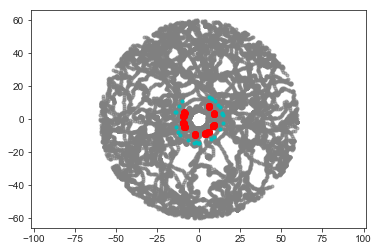

In [839]:
# Check if alignment is correct
plt.plot(xtrial,ytrial,'.',color='grey', alpha=0.6)
plt.plot(xtrial[ev>0],ytrial[ev>0],'ro')
plt.plot(xtrial[entries>0],ytrial[entries>0],'c.')
plt.axis('equal')
print(fly)

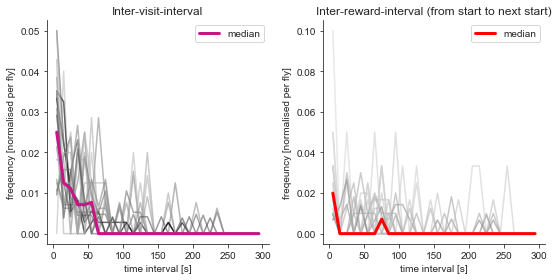

In [840]:
entrydistfig, axs = plt.subplots(1,2, figsize=(8,4))

binEds = bin_edges[:-1]+np.diff(bin_edges[:2])/2

# generate colormap encoding total number of visits
cNorm  = colors.Normalize(vmin=-10, vmax=max(numEntries))
entryCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Greys')

# plot distribution
for fly in range(numFlies):
    axs[0].plot(binEds,flyEntryTimeDistr[fly,:], 
                    color=entryCMap.to_rgba(numEntries[fly]), alpha=0.6, label='')
    axs[1].plot(binEds,flyRewardStTimeDistr[fly,:], 
                    color=entryCMap.to_rgba(numRewards[fly]), alpha=0.6, label='')
axs[0].plot(binEds,np.nanmedian(flyEntryTimeDistr,axis=0), color='mediumvioletred', linewidth=3, label='median')
axs[0].set_title('Inter-visit-interval')

axs[1].plot(binEds,np.nanmedian(flyRewardStTimeDistr,axis=0), color='red', linewidth=3, label='median')
axs[1].set_title('Inter-reward-interval (from start to next start)')

for ax in axs:
    myAxisTheme(ax)
    ax.set_xlabel('time interval [s]')
    ax.set_ylabel('freqeuncy [normalised per fly]')
    ax.legend()
        
entrydistfig.tight_layout()

entrydistfig.savefig(analysisDir + 'interVisitInterval/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
           +'_interEventIntervalDistr_singleFly_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

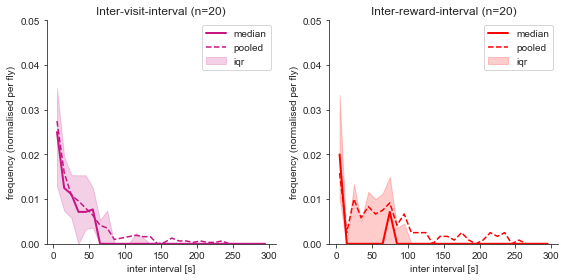

In [841]:
entrydistfig, axs = plt.subplots(1,2,figsize=(8,4))

binEds = bin_edges[:-1]+np.diff(bin_edges[:2])/2

[qt25, qt50, qt75] = np.nanpercentile(flyEntryTimeDistr[:,:],[25,50,75],axis=0)
axs[0].plot(binEds,qt50, color='mediumvioletred', linewidth=2, label='median')
axs[0].fill_between(binEds,qt25, qt75, color='mediumvioletred', linewidth=1, label='iqr', alpha=0.2)

hist, bin_edges = np.histogram(allInterEntryTimes, bins=numBins, range=binRange, density=True)
axs[0].plot(binEds,hist, color='mediumvioletred', linewidth=1.5, linestyle='dashed', label='pooled')

axs[0].set_title('Inter-visit-interval (n='+str(numFlies)+')')
interVisitIntervalDistr = [qt25,qt50,qt75,hist]

[qt25, qt50, qt75] = np.nanpercentile(flyRewardStTimeDistr[:,:],[25,50,75],axis=0)
axs[1].plot(binEds,qt50, color='red', linewidth=2, label='median')
axs[1].fill_between(binEds,qt25, qt75, color='red', linewidth=1, label='iqr', alpha=0.2)

hist, bin_edges = np.histogram(allRewardTimes, bins=numBins, range=binRange, density=True)
axs[1].plot(binEds,hist, color='red', linewidth=1.5, linestyle='dashed', label='pooled')

axs[1].set_title('Inter-reward-interval (n='+str(numFlies)+')')
interRewardIntervalDistr = [qt25,qt50,qt75,hist]


for ax in axs:
    myAxisTheme(ax)
    ax.legend()
    ax.set_ylim(0,.05)
    ax.set_xlabel('inter interval [s]')
    ax.set_ylabel('frequency (normalised per fly)')

entrydistfig.tight_layout()

np.save(analysisDir + 'interVisitInterval/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
           +'_interVisitInterval_percentile25-50-75_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
           +selectionTag, interVisitIntervalDistr)
np.save(analysisDir + 'interVisitInterval/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
           +'_interRewardInterval_percentile25-50-75_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
           +selectionTag, interRewardIntervalDistr)

entrydistfig.savefig(analysisDir + 'interVisitInterval/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
           +'_interEventIntervalDistr_medianIQR_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

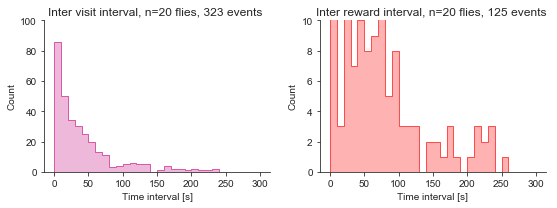

In [842]:
entrydistfig, axs = plt.subplots(1,2,figsize=(8,3))

binEds = bin_edges[:-1]+np.diff(bin_edges[:2])/2

labelTxt = ['visit', 'reward']
axs[0].hist(allInterEntryTimes, bins=numBins, range=binRange, color='mediumvioletred',histtype='step')
axs[0].hist(allInterEntryTimes, bins=numBins, range=binRange, color='mediumvioletred',histtype='stepfilled', alpha=0.3)
axs[0].set_ylim(0,100)
axs[0].set_title('Inter {} interval, n={} flies, {} events '.format(labelTxt[0], numFlies, len(allInterEntryTimes)))

axs[1].hist(allRewardTimes, bins=numBins, range=binRange, color='red', histtype='step')
axs[1].hist(allRewardTimes, bins=numBins, range=binRange, color='red', histtype='stepfilled', alpha=0.3)

axs[1].set_ylim(0,10)
axs[1].set_title('Inter {} interval, n={} flies, {} events '.format(labelTxt[1], numFlies, len(allRewardTimes)))

for i, ax in enumerate(axs):
    myAxisTheme(ax)
    ax.set_xlabel('Time interval [s]')
    ax.set_ylabel('Count') #frequency (normalised per fly)

entrydistfig.tight_layout()

entrydistfig.savefig(analysisDir + 'interVisitInterval/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
           +'_interEventIntervalHist_pooled_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

## Movement changes triggered on reinforcement events


In [843]:
def getPathEnd(i, evStart, T, wind):
    if evStart[i]+wind > T:
        return np.nan
    
    if i+1<len(evStart): #not the last event
        if evStart[i+1] - evStart[i] == 1 or evStart[i]+wind > evStart[i+1] or evStart[i]+wind > T: 
            #if same reinforcement event as next one or trunkated by end of trial or next reinforcement event
            return np.nan
        
    return evStart[i]+wind

## Trigger on reinforcement and plot *walking velocities* for following x seconds (or until next reinforcement is delivered)

In [844]:
try:
    mkdir(analysisDir + 'reinforcementEffect/')
except:
    print('Plot directory already exists')

Plot directory already exists


In [845]:
tmax = 20
tmin = -5
window = int(fps*tmax)
prewindow = int(fps*-tmin)

triggVT = np.nan*np.ones((numFlies,window+prewindow))
triggVR = np.nan*np.ones((numFlies,window+prewindow))

for fly in range(numFlies):
    querystring = ' (flyID == "'+flyIDs[fly]+'")'
    vt = FOAllFlies_df.query(querystring)['transVelo'].values.squeeze()
    vr = FOAllFlies_df.query(querystring)['rotVelo'].values.squeeze()
    ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    time = FOAllFlies_df.query(querystring)['time'].values.squeeze()

    evStart = np.where(ev>evLevel)[0]

    flyVT = []
    flyVR = []
    for i, es in enumerate(evStart):
        pathSt = es-prewindow
        pathEd = getPathEnd(i, evStart, len(vt), window)
        if np.isnan(pathEd) or pathSt<0: continue
            
        vti = vt[pathSt:pathEd]
        vri = abs(vr[pathSt:pathEd])
        timeax = np.linspace(tmin,time[pathEd]-time[es], pathEd-pathSt)
        
        if vti.size == 0:
            continue

        flyVT.append(vti)
        flyVR.append(vri)

    for k in range(len(triggVT[0])):
        val = []
        for sl in flyVT:
            if k < len(sl):
                val.append(sl[k])
        triggVT[fly,k] = np.nanmean(np.asarray(val))
        
        val = []
        for sl in flyVR:
            if k < len(sl):
                val.append(sl[k])
        triggVR[fly,k] = np.nanmean(np.asarray(val))

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


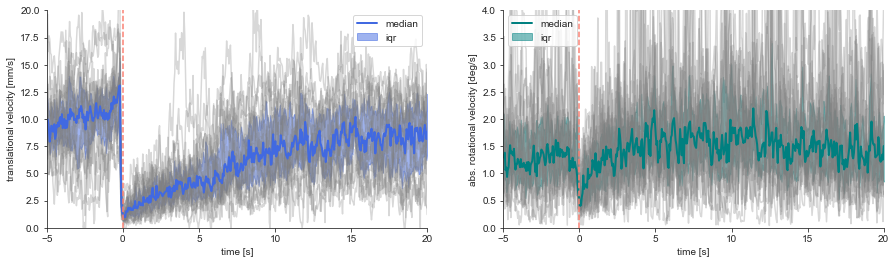

In [846]:
fig, axs = plt.subplots(1,2,figsize=(15,4))

timeax = np.linspace(tmin,tmax, window+prewindow)
for fly in range(numFlies):
    axs[0].plot(timeax,triggVT[fly,:], color='grey',alpha=0.3, label='')
    
[qt25, qt50, qt75] = np.nanpercentile(triggVT,[25,50,75],axis=0)
axs[0].plot(timeax,qt50, color='royalblue', linewidth=2, label='median')
axs[0].fill_between(timeax,qt25, qt75, color='royalblue', linewidth=1, label='iqr', alpha=0.5)

for fly in range(numFlies):
    axs[1].plot(timeax,triggVR[fly,:], color='grey',alpha=0.3, label='')
    
[qt25, qt50, qt75] = np.nanpercentile(triggVR,[25,50,75],axis=0)
axs[1].plot(timeax,qt50, color='teal', linewidth=2, label='median')
axs[1].fill_between(timeax,qt25, qt75, color='teal', linewidth=1, label='iqr', alpha=0.5)

for ax in axs:
    myAxisTheme(ax)
    ax.legend()
    ax.set_xlabel('time [s]')
    ax.axvline(0,0,1,color='salmon', linestyle='dashed', linewidth=1.5)
    ax.set_xlim(tmin, tmax)
axs[0].set_ylim(0,20)
axs[1].set_ylim(0,4)
axs[0].set_ylabel('translational velocity [mm/s]')
axs[1].set_ylabel('abs. rotational velocity [deg/s]')
    

np.save(analysisDir + 'reinforcementEffect/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
           +'_trigRotVelo_medianIQRAcrossFlies_'+str(tmax)+'s_n'+ str(len(flyIDs))+selectionTag, triggVR)
np.save(analysisDir + 'reinforcementEffect/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
           +'_trigTransVelo_medianIQRAcrossFlies_'+str(tmax)+'s_n'+ str(len(flyIDs))+selectionTag, triggVT)

fig.savefig(analysisDir + 'reinforcementEffect/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
    +'_triggeredVelo_medianIQRAcrossFlies_'+str(tmax)+'s_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

## Trigger on reinforcement and plot *absolute distance moved* for following x seconds (or until next reinforcement is delivered)

In [847]:
try:
    mkdir(analysisDir + 'distanceMoved/')
except:
    print('Plot directory already exists')

Plot directory already exists


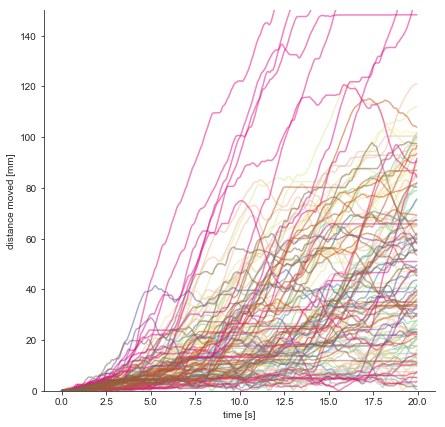

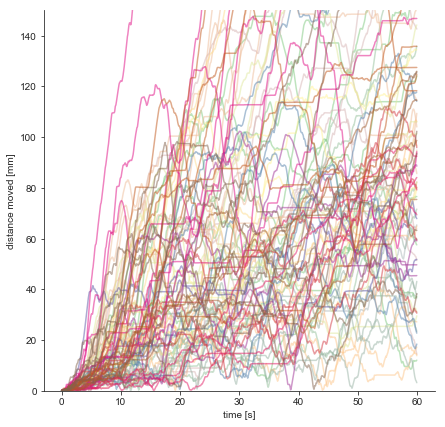

In [848]:
for wind in [windowMax, 60]:
    window = int(fps*wind)

    fig, ax = plt.subplots(1,1, figsize=(7,7))

    distAllEvents = []

    for fly in range(numFlies):
        querystring = '(flyID == "'+flyIDs[fly]+'")'
        xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
        ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
        ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
        time = FOAllFlies_df.query(querystring)['time'].values.squeeze()

        evStart = np.where(ev>evLevel)[0]

        distSingleFly = []

        for i, es in enumerate(evStart):
            pathSt = es
            pathEd = getPathEnd(i, evStart, len(xtrial), window)
            if np.isnan(pathEd):
                continue
            pathX = xtrial[pathSt:pathEd]-xtrial[pathSt]
            pathY = ytrial[pathSt:pathEd]-ytrial[pathSt]
            dist = np.hypot(pathX,pathY)

            ax.plot(time[pathSt:pathEd]-time[pathSt],dist,color=flyCMap.to_rgba(fly),alpha=0.5)
            if len(dist)>=window:
                distSingleFly.append(dist)

        distAllEvents.append(np.asarray(distSingleFly))

    ax.set_ylim(0,150)
    ax.set_xlabel('time [s]')
    ax.set_ylabel('distance moved [mm]')
    myAxisTheme(ax)

    fig.savefig(analysisDir + 'distanceMoved/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
               +'_distPostReward_'+str(int(wind))+'s_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

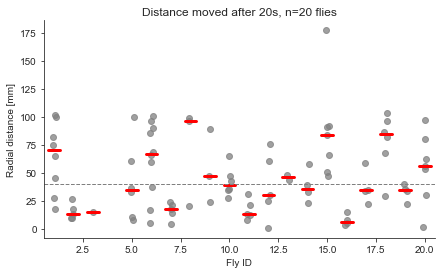

In [849]:
distMovedPerFly, ax = plt.subplots(1,1,figsize=(7,4))

evtime = windowMax

for fly in range(numFlies):
    distFly = distAllEvents[fly]
    cltvals = []
    for i in range(len(distFly)):
        ax.plot(1+fly-0.1+np.random.rand(1)/5, distFly[i][int(evtime*fps)-1],'o', color='grey',alpha=0.75)
        cltvals.append(distFly[i][int(evtime*fps)-1])
        
    if len(distFly)>0:
        ax.plot([1+fly-0.3, 1+fly+0.3],[np.median(cltvals), np.median(cltvals)], color='red', linewidth=3)
        
ax.axhline(40, 0,1, color='grey', linewidth=1, linestyle='dashed')

myAxisTheme(ax)
ax.set_xlim(0.5,numFlies+0.5)
ax.set_xlabel('Fly ID')
ax.set_ylabel('Radial distance [mm]')
ax.set_title('Distance moved after {}s, n={} flies'.format(evtime, numFlies))

distMovedPerFly.savefig(analysisDir + 'distanceMoved/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
          +'_distPostRewardPerEvAndFly_after'+str(evtime)+'s_n'+ str(len(flyIDs))+selectionTag+'.pdf', format='pdf')

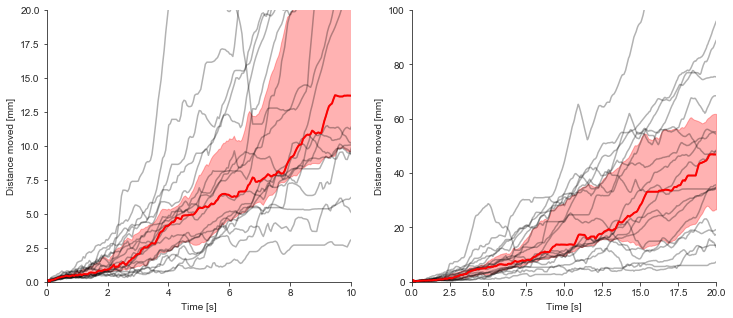

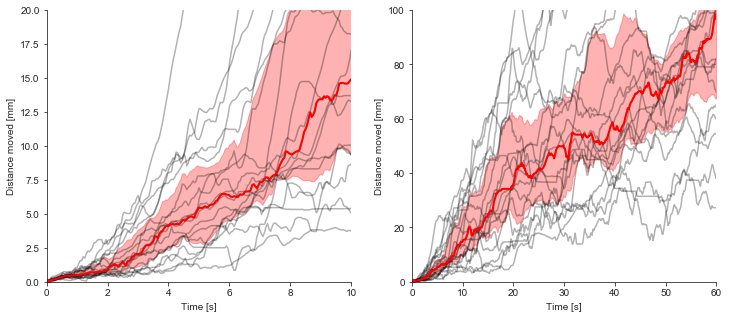

In [850]:
for wind in [windowMax, 60]:
    # Only take into account path fragments that are full lenght of window

    tmax = [10, wind]
    ymax = [20, 100]
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    window = int(fps*tmax[1])
    timeax = np.linspace(0,tmax[1], window)

    distAll = np.nan*np.ones((numFlies, window))

    for fly in range(numFlies):
        querystring = '(flyID == "'+flyIDs[fly]+'")'
        xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
        ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
        ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
        time = FOAllFlies_df.query(querystring)['time'].values.squeeze()

        evStart = np.where(ev>evLevel)[0]

        dist = np.nan*np.ones((len(evStart), window))
        for k, es in enumerate(evStart):
            pathSt = es
            pathEd = getPathEnd(k, evStart, len(xtrial),window)
            if np.isnan(pathEd):continue

            pathX = xtrial[pathSt:pathEd]-xtrial[pathSt]
            pathY = ytrial[pathSt:pathEd]-ytrial[pathSt]

            if len(pathY)>=window:
                dist[k,:] = np.hypot(pathX,pathY)

        for i in range(2):    
            ax[i].plot(timeax,np.nanmedian(dist, axis=0),'k', alpha=0.3)

        distAll[fly,:] = np.nanmedian(dist, axis=0)

    for i in range(2):
        [qt25, qt50, qt75] = np.nanpercentile(distAll,[25,50,75],axis=0)

        ax[i].plot(timeax,qt50, color='red', linewidth=2, label='median')
        ax[i].fill_between(timeax,qt25, qt75, color='red', linewidth=1, label='iqr', alpha=0.3)

        ax[i].plot(0,0,'ro')
        ax[i].set_xlim(0,tmax[i])
        ax[i].set_ylim(0,ymax[i])
        ax[i].set_xlabel('Time [s]')
        ax[i].set_ylabel('Distance moved [mm]')
        myAxisTheme(ax[i])

    np.save(analysisDir + 'distanceMoved/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
               +'_distAfterRewardMedianFly_'+str(int(wind))+'s_n'+ str(len(flyIDs))
               +selectionTag, distAll)

    fig.savefig(analysisDir + 'distanceMoved/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
               +'_distPostRewardMedianFly_'+str(int(wind))+'s_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

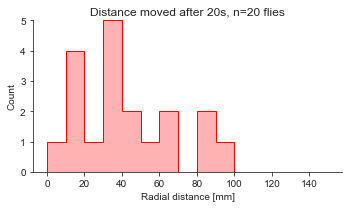

In [851]:
distMovedHist, ax = plt.subplots(1,1,figsize=(5,3))

evtime = windowMax
binrange = (0,150)
ax.hist(distAll[:,int(evtime*fps)-1][~np.isnan(distAll[:,int(evtime*fps)-1])], range=binrange, bins=15, color='red', histtype='stepfilled', alpha=0.3)
ax.hist(distAll[:,int(evtime*fps)-1][~np.isnan(distAll[:,int(evtime*fps)-1])], range=binrange, bins=15, color='red', histtype='step')
ax.set_ylim(0,5)
ax.set_title('Distance moved after {}s, n={} flies'.format(evtime, numFlies, len(allRewardTimes)))

myAxisTheme(ax)
ax.set_xlabel('Radial distance [mm]')
ax.set_ylabel('Count')

distMovedHist.tight_layout()

distMovedHist.savefig(analysisDir + 'distanceMoved/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
          +'_distPostRewardHist_post'+str(evtime)+'s_n'+ str(len(flyIDs))+selectionTag+'.pdf', format='pdf')

## Quantify "curvyness of path"  (tortuosity)

In [810]:
try:
    mkdir(analysisDir + 'curvyness/')
except:
    print('Plot directory already exists')

Plot directory already exists


In [811]:
def tortuosity(x,y,windowsize):
    T = len(x)
    
    tu = np.nan*np.ones(T-windowsize)
    
    for t in range(windowsize,T):
        xw = x[t-windowsize:t]
        yw = y[t-windowsize:t]
        
        pathLen = sum(np.hypot(np.diff(xw), np.diff(yw)))
        totalDist = np.hypot((x[t]-x[t-windowsize]), (y[t]-y[t-windowsize]))
        
        tu[t-windowsize] = pathLen/totalDist
    
    return tu

In [812]:
window = int(fps*windowMax)
slidWind = int(2*fps) #s

In [813]:
tuAllEvents = []
for fly in range(numFlies):
    querystring = '(flyID == "'+flyIDs[fly]+'")'
    xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
    ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
    ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    time = FOAllFlies_df.query(querystring)['time'].values.squeeze()
    evStart = np.where(ev>evLevel)[0]
    tuSingleFly = []
    
    for i, es in enumerate(evStart):
        pathSt = es
        if i+1<len(evStart):
            if evStart[i+1] - es == 1:
                continue
            pathEd = min(es+window, evStart[i+1])
        else:
            pathEd = min(es+window, len(ev))
        pathX = xtrial[pathSt:pathEd]-xtrial[pathSt]
        pathY = ytrial[pathSt:pathEd]-ytrial[pathSt]
        
        if pathX.size <= slidWind:
            continue
            
        tu = tortuosity(pathX,pathY,slidWind)
        timeax = time[pathSt+slidWind:pathEd]-time[pathSt]
        if len(tu)>=window:
            tuSingleFly.append(tu)
    tuAllEvents.append(np.asarray(tuSingleFly))

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


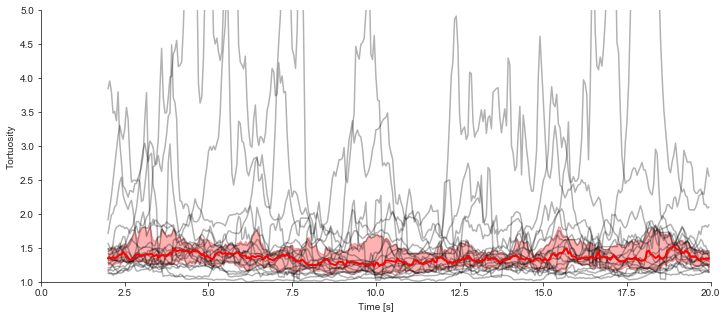

In [814]:
tmax = windowMax
ymax = 5
fig, ax = plt.subplots(1,1, figsize=(12,5))
window = int(fps*tmax)
timeax = np.linspace(slidWind/fps,tmax, window-slidWind)

tuAll = np.nan*np.ones((numFlies, window-slidWind))

for fly in range(numFlies):
    querystring = '(flyID == "'+flyIDs[fly]+'")'
    xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
    ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
    ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    time = FOAllFlies_df.query(querystring)['time'].values.squeeze()

    evStart = np.where(ev>evLevel)[0]

    tus = np.nan*np.ones((len(evStart), window-slidWind))
    for k, es in enumerate(evStart):
        pathSt = es
        pathEd = getPathEnd(k, evStart, len(xtrial),window)
        if np.isnan(pathEd):continue
            
        pathX = xtrial[pathSt:pathEd]-xtrial[pathSt]
        pathY = ytrial[pathSt:pathEd]-ytrial[pathSt]
        
        if pathX.size <= slidWind:
            continue
            
        tu = tortuosity(pathX,pathY,slidWind)
        timeax = time[pathSt+slidWind:pathEd]-time[pathSt]
        
        if not len(tu) < (window-slidWind):
            tus[k,:] = tu
                   
    ax.plot(timeax,np.nanmedian(tus, axis=0),'k', alpha=0.3)

    tuAll[fly,:] = np.nanmedian(tus, axis=0)

[qt25, qt50, qt75] = np.nanpercentile(tuAll,[25,50,75],axis=0)

ax.plot(timeax,qt50, color='red', linewidth=2, label='median')
ax.fill_between(timeax,qt25, qt75, color='red', linewidth=1, label='iqr', alpha=0.3)

ax.set_xlim(0,tmax)
ax.set_ylim(1,ymax)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Tortuosity')
myAxisTheme(ax)

np.save(analysisDir + 'curvyness/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
           +'_tortuosityPostRewardMedianFly_window'+str(int(slidWind/fps))+'s_'+str(windowMax)+'s_n'+ str(len(flyIDs))
           +selectionTag, tuAll)

fig.savefig(analysisDir + 'curvyness/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
           +'_tortuosityPostRewardMedianFly_window'+str(int(slidWind/fps))+'s_'+str(windowMax)+'s_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

## Plot trajectory fragments after reward events for all flies
### Fixed amount of time pre/post event

In [657]:
windowPre = int(20*fps)
windowPost = int(20*fps)
plotScale = gridSize

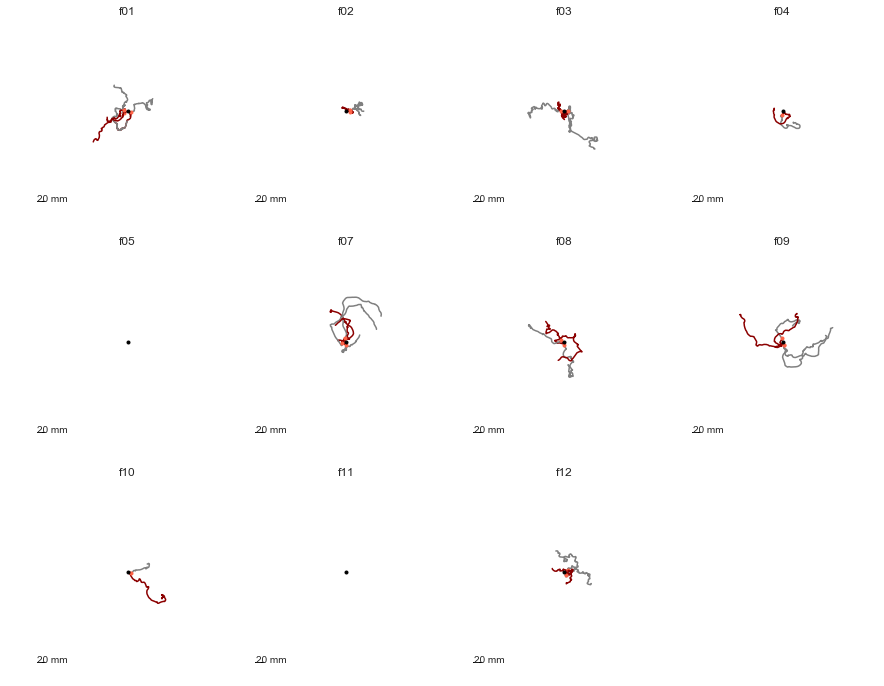

In [658]:
# choose how many events per fly max:
maxpath = 3
nrows = np.ceil(numFlies/4.0)

multiflyTraceFig = plt.figure(figsize=(15,4*nrows))
for fly in range(numFlies):
    sbplt = multiflyTraceFig.add_subplot(nrows,4,fly+1)

    querystring = '(flyID == "'+flyIDs[fly]+'")'
    xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
    ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
    ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    evStart = np.where(ev>evLevel)[0]
    count = 1
    if len(evStart) > 0:
        i = 0
        es = evStart[0]
    
        for i, es in enumerate(evStart):
            pathSt = es-windowPre
            pathEd = getPathEnd(i, evStart, len(xtrial), windowPost)
            if np.isnan(pathEd) or pathSt<0: continue

            objCoord = [0,0]
            # find closest object at event time
            for i, vc in enumerate(objcoord):
                # ...find points that are close and project them to the origin
                distToObj = np.hypot(xtrial[es]-vc[0], ytrial[es]-vc[1])
                if distToObj < 1.5*rewardRad:
                    objCoord = vc
                    continue
                        
            sbplt.plot(xtrial[es-windowPre:es]-objCoord[0], ytrial[es-windowPre:es]-objCoord[1], color='grey')
            sbplt.plot(xtrial[es:es+windowPost]-objCoord[0], ytrial[es:es+windowPost]-objCoord[1], color='darkred')
            sbplt.plot(xtrial[es]-objCoord[0], ytrial[es]-objCoord[1],'.', color='tomato')
            count = count + 1
            if count > maxpath:
                break
    sbplt.plot([-plotScale,-plotScale+20],[-plotScale,-plotScale],'k', linewidth=3)
    sbplt.text(-plotScale+2,-plotScale+2,'20 mm')
    sbplt.plot(0,0,'k.') 
    sbplt.set_aspect('equal')
    sbplt.set_title(flyIDs[fly])
    sbplt.set_axis_off()
    sbplt.set_xlim(-plotScale,plotScale)
    sbplt.set_ylim(-plotScale,plotScale)

multiflyTraceFig.savefig(analysisDir + 'tracePlot/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
           +'_'+str(maxpath)+'pathsAroundReward_pre'+str(int(windowPre/fps))+'s_post'+str(int(windowPost/fps))+'s_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### All paths + center of mass

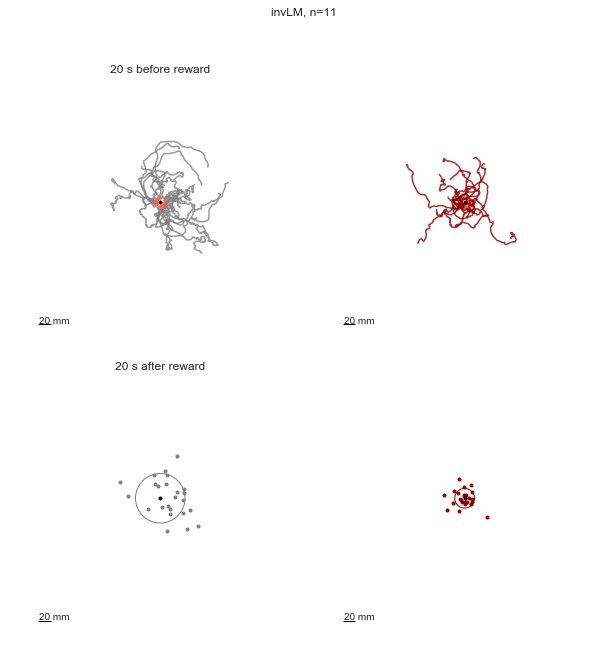

In [659]:
nrows = np.ceil(numFlies/4.0)

pathFig, axs = plt.subplots(2,2,figsize=(10,10))

cmPre = []
cmPost = []

for fly in range(numFlies):
    querystring = '(flyID == "'+flyIDs[fly]+'")'
    xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
    ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
    ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    evStart = np.where(ev>evLevel)[0]

    for i, es in enumerate(evStart):
        pathSt = es-windowPre
        pathEd = getPathEnd(i, evStart, len(xtrial), windowPost)
        if np.isnan(pathEd) or pathSt<0: continue

        objCoord = [0,0]
        # find closest object at event time
        for i, vc in enumerate(objcoord):
            # ...find points that are close and project them to the origin
            distToObj = np.hypot(xtrial[es]-vc[0], ytrial[es]-vc[1])
            if distToObj < 1.5*rewardRad:
                objCoord = vc
                continue
    
        axs[0,0].plot(xtrial[es-windowPre:es]-objCoord[0], ytrial[es-windowPre:es]-objCoord[1], color='grey',alpha=0.8)
        axs[0,0].plot(xtrial[es]-objCoord[0], ytrial[es]-objCoord[1],'.', color='tomato')
        axs[0,1].plot(xtrial[es:es+windowPost]-objCoord[0], ytrial[es:es+windowPost]-objCoord[1], color='darkred',alpha=0.8)
        axs[0,1].plot(xtrial[es]-objCoord[0], ytrial[es]-objCoord[1],'.', color='tomato')
        
        cmx = np.mean(xtrial[es-windowPre:es]-objCoord[0]); cmy = np.mean(ytrial[es-windowPre:es]-objCoord[1])
        cmPre.append((cmx,cmy))
        axs[1,0].plot(cmx, cmy, '.', color='grey')
        cmx = np.mean(xtrial[es:es+windowPost]-objCoord[0]); cmy = np.mean(ytrial[es:es+windowPost]-objCoord[1])
        cmPost.append((cmx,cmy))
        axs[1,1].plot(cmx, cmy, '.', color='darkred')


axs[0,0].set_title('{} s before reward'.format(int(windowPre/fps)))
axs[1,0].set_title('{} s after reward'.format(int(windowPost/fps)))

cmPrex = [cm[0] for cm in cmPre]; cmPrey = [cm[1] for cm in cmPre]
radDistances = np.hypot(cmPrex,cmPrey)
circle = plt.Circle((0,0), np.mean(radDistances), edgecolor='grey', facecolor='none')
axs[1,0].add_artist(circle)

cmPostx = [cm[0] for cm in cmPost]; cmPosty = [cm[1] for cm in cmPost]
radDistances = np.hypot(cmPostx,cmPosty)
circle = plt.Circle((0,0), np.mean(radDistances), edgecolor='darkred', facecolor='none')
axs[1,1].add_artist(circle)

for j in range(2):
    for i in range(2):
        axs[i,j].plot(0,0,'k.') 
        axs[i,j].set_aspect('equal')
        axs[i,j].set_axis_off()
        axs[i,j].set_xlim(-plotScale,plotScale)
        axs[i,j].set_ylim(-plotScale,plotScale)
        axs[i,j].plot([-plotScale+5,-plotScale+25],[-plotScale,-plotScale],'k', linewidth=3)
        axs[i,j].text(-plotScale+5,-plotScale+5,'20 mm')


pathFig.suptitle('{}, n={}'.format(protocol, numFlies))
    
pathFig.savefig(analysisDir + 'tracePlot/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
           +'_allPathAndCOMAroundReward_pre'+str(int(windowPre/fps))+'s_post'+str(int(windowPost/fps))+'s_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### Parameterize by path length

In [551]:
# path length in mm
mult =1.5 # 3
windowPre = 100*mult
windowPost = windowPre
plotScale = gridSize

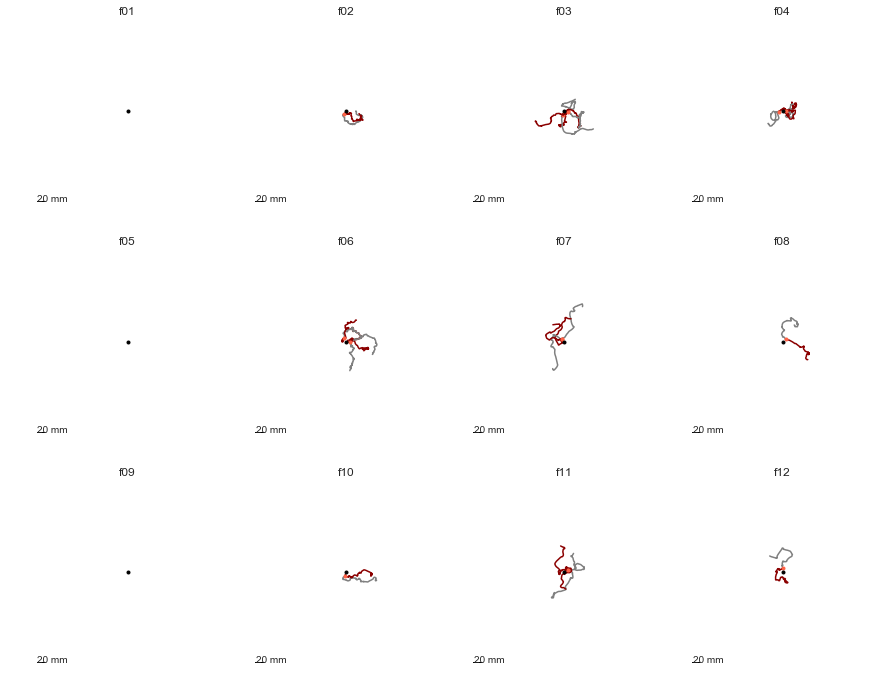

In [552]:
maxpath = 3
nrows = np.ceil(numFlies/4.0)

multiflyTraceFig = plt.figure(figsize=(15,4*nrows))
for fly in range(numFlies):
    sbplt = multiflyTraceFig.add_subplot(nrows,4,fly+1)

    querystring = '(flyID == "'+flyIDs[fly]+'")'
    xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
    ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
    ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    evStart = np.where(ev>evLevel)[0]
    prevSt = 0
    count = 1
    for i, es in enumerate(evStart):
        if i+1 < len(evStart) and evStart[i+1] - es == 1:
            continue
        
        xes = xtrial[es]
        yes = ytrial[es]
        
        # find start time
        pathLen = 0
        prei = 0
        while pathLen < windowPre:
            prei = prei+1
            if es-prei < 0 or es-prei < prevSt: break # trunkated by start of trial or by previous event
            pathLen = pathLen + np.hypot(xtrial[es-prei]-xtrial[es-(prei-1)], ytrial[es-prei]-ytrial[es-(prei-1)])
        
        # find end time
        pathLen = 0
        posti = 0
        while pathLen < windowPost:  
            posti = posti+1
            if es+posti+1 > len(xtrial): break  # trunkated by end of trial or by next event
            if i+1 < len(evStart) and es+posti > evStart[i+1]: break
            pathLen = pathLen + np.hypot(xtrial[es+posti]-xtrial[es+(posti-1)], ytrial[es+posti]-ytrial[es+(posti-1)])
        
        if es+posti+1 > len(xtrial):
            continue
        
        objCoord = [0,0]
        # find closest object at event time
        for i, vc in enumerate(objcoord):
            # ...find points that are close and project them to the origin
            distToObj = np.hypot(xes-vc[0], yes-vc[1])
            if distToObj < 1.5*rewardRad:
                objCoord = vc
                continue
                    
        sbplt.plot(xtrial[es-prei:es]-objCoord[0], ytrial[es-prei:es]-objCoord[1], color='grey')
        sbplt.plot(xtrial[es:es+posti]-objCoord[0], ytrial[es:es+posti]-objCoord[1], color='darkred')
        sbplt.plot(xes-objCoord[0], yes-objCoord[1],'.', color='tomato')
        count = count + 1
        
        if count > maxpath:
            break
        
    sbplt.plot([-plotScale,-plotScale+20],[-plotScale,-plotScale],'k', linewidth=3)
    sbplt.text(-plotScale+2,-plotScale+2,'20 mm')  
    sbplt.plot(0,0,'k.') 
    sbplt.set_aspect('equal')
    sbplt.set_title(flyIDs[fly])
    sbplt.set_axis_off()
    sbplt.set_xlim(-plotScale,plotScale)
    sbplt.set_ylim(-plotScale,plotScale)

multiflyTraceFig.savefig(analysisDir + 'tracePlot/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
           +'_'+str(maxpath)+'pathsAroundReward_pre'+str(windowPre)+'mm_post'+str(windowPost)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### Pooled paths and center of mass of path fragments before and after reward

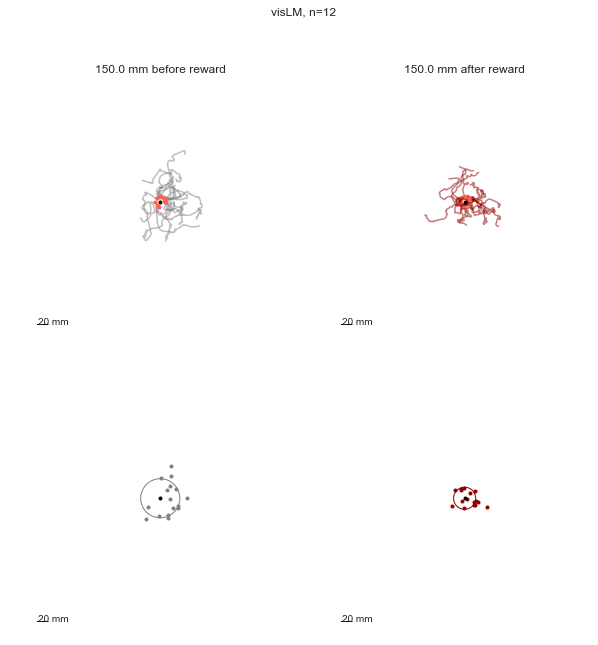

In [553]:
maxpath = 1000
pathFig, axs = plt.subplots(2,2,figsize=(10,10))

cmPre = []
cmPost = []

for fly in range(numFlies):
    querystring = '(flyID == "'+flyIDs[fly]+'")'
    xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
    ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
    ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    evStart = np.where(ev>evLevel)[0]
    
    prevSt = 0
    count = 1
    for i, es in enumerate(evStart):
        if i+1 < len(evStart) and evStart[i+1] - es == 1:
            continue
        
        xes = xtrial[es]
        yes = ytrial[es]
        
        # find start time
        pathLen = 0
        prei = 0
        while pathLen < windowPre:
            prei = prei+1
            if es-prei < 0 or es-prei < prevSt: break # trunkated by start of trial or by previous event
            pathLen = pathLen + np.hypot(xtrial[es-prei]-xtrial[es-(prei-1)], ytrial[es-prei]-ytrial[es-(prei-1)])
        
        # find end time
        pathLen = 0
        posti = 0
        while pathLen < windowPost:  
            posti = posti+1
            if es+posti+1 > len(xtrial): break  # trunkated by end of trial or by next event
            if i+1 < len(evStart) and es+posti > evStart[i+1]: break
            pathLen = pathLen + np.hypot(xtrial[es+posti]-xtrial[es+(posti-1)], ytrial[es+posti]-ytrial[es+(posti-1)])
        
        if es+posti+1 > len(xtrial):
            continue
        
        objCoord = [0,0]
        # find closest object at event time
        for i, vc in enumerate(objcoord):
            # ...find points that are close and project them to the origin
            distToObj = np.hypot(xes-vc[0], yes-vc[1])
            if distToObj < 1.5*rewardRad:
                objCoord = vc
                continue
                    
        axs[0,0].plot(xtrial[es-prei:es]-objCoord[0], ytrial[es-prei:es]-objCoord[1], color='grey', alpha=0.5)
        axs[0,1].plot(xtrial[es:es+posti]-objCoord[0], ytrial[es:es+posti]-objCoord[1], color='darkred', alpha=0.5)
        for i in range(2):
            axs[0,i].plot(xes-objCoord[0], yes-objCoord[1],'.', color='tomato') 

            
        cmx = np.mean(xtrial[es-prei:es]-objCoord[0]); cmy = np.mean(ytrial[es-prei:es]-objCoord[1])
        cmPre.append((cmx,cmy))
        axs[1,0].plot(cmx, cmy, '.', color='grey')
        cmx = np.mean(xtrial[es:es+posti]-objCoord[0]); cmy = np.mean(ytrial[es:es+posti]-objCoord[1])
        cmPost.append((cmx,cmy))
        axs[1,1].plot(cmx, cmy, '.', color='darkred')
        
        prevSt = es
        count = count + 1
        
        if count > maxpath:
            break
        
axs[0,0].set_title('{} mm before reward'.format(windowPre))
axs[0,1].set_title('{} mm after reward'.format(windowPost))

cmPrex = [cm[0] for cm in cmPre]; cmPrey = [cm[1] for cm in cmPre]
radDistances = np.hypot(cmPrex,cmPrey)
circle = plt.Circle((0,0), np.nanmean(radDistances), edgecolor='grey', facecolor='none')
axs[1,0].add_artist(circle)

cmPostx = [cm[0] for cm in cmPost]; cmPosty = [cm[1] for cm in cmPost]
radDistances = np.hypot(cmPostx,cmPosty)
circle = plt.Circle((0,0), np.nanmean(radDistances), edgecolor='darkred', facecolor='none')
axs[1,1].add_artist(circle)

for i in range(2):
    for j in range(2):
        axs[i,j].plot(0,0,'k.') 
        axs[i,j].set_aspect('equal')
        axs[i,j].set_axis_off()
        axs[i,j].set_xlim(-plotScale,plotScale)
        axs[i,j].set_ylim(-plotScale,plotScale)
        axs[i,j].plot([-plotScale,-plotScale+20],[-plotScale,-plotScale],'k', linewidth=3)
        axs[i,j].text(-plotScale+2,-plotScale+2,'20 mm')


pathFig.suptitle('{}, n={}'.format(protocol, numFlies))
if maxpath >= 1000:
    pathFig.savefig(analysisDir + 'tracePlot/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
           +'allpathsAndCOMAroundRewardPooled_pre'+str(windowPre)+'mm_post'+str(windowPost)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')
else:
    pathFig.savefig(analysisDir + 'tracePlot/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
           +'_'+str(maxpath)+'pathsAndCOMAroundRewardPooled_pre'+str(windowPre)+'mm_post'+str(windowPost)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

## Return rates after reward encounter

####  (1) Visits around reward event
#### (2) Compute re-visits of landmark closest to reward after each reward event
#### (3) Compute ANY landmark visits after each reward event

In [554]:
try:
    mkdir(analysisDir + 'revisits/')
except:
    print('Plot directory already exists')

Plot directory already exists


In [555]:
windowMax = 60 # 20,60

rewardRad = 10
window = int(fps*windowMax)

In [556]:
visitCountAll = []
revisitLMCountAll = []

for fly in range(numFlies):
    querystring = '(flyID == "'+flyIDs[fly]+'")'
    xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
    ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
    ttrial = FOAllFlies_df.query(querystring)['time'].values.squeeze()
    ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    evStart = np.where(ev>evLevel)[0]

    visitRewCount = []
    visitLMCount = []
    for i, es in enumerate(evStart):
        pathEd = getPathEnd(i, evStart, len(xtrial),window)
        if np.isnan(pathEd):continue
        
        # find closest object at event time
        objCoord = np.nan*np.ones(2)
        for i, vc in enumerate(objcoord):
            # ...find points that are close and project them to the origin
            distToObj = np.hypot(xtrial[es]-vc[0], ytrial[es]-vc[1])
            if distToObj < 1.5*rewardRad:
                objCoord = vc
                #sbplt.plot(vc[0],vc[1],'k.')  
                continue
        
        x = xtrial[es:pathEd]
        y = ytrial[es:pathEd]
        t = ttrial[es:pathEd]
        
        dist2ev = np.hypot(x-xtrial[es], y-ytrial[es])

        entries,exits,visitT,entryTime,exitTime = countvisits(dist2ev,t,visitRad)
        visitRewCount.append(sum(entries))
        
        dist2LM = np.hypot(x-objCoord[0], y-objCoord[1])

        entries,exits,visitT,entryTime,exitTime = countvisits(dist2LM,t,visitRad)
        visitLMCount.append(sum(entries))
                
    visitCountAll.append(visitRewCount)
    revisitLMCountAll.append(visitLMCount)


visitCountAllList = [val for sublist in visitCountAll for val in sublist]

np.save(analysisDir + 'revisits/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
        +'_revisitsAfterRewardCounts_window_'+str(windowMax)+'s_visitRad'+str(visitRad)+'mm_n'+ 
        str(len(flyIDs))+selectionTag, visitCountAll)

revisitLMCountAllList = [val for sublist in revisitLMCountAll for val in sublist]

np.save(analysisDir + 'revisits/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
         +'_LMrevisitsAfterRewardCounts_window_'+str(windowMax)+'s_visitRad'
        +str(visitRad)+'mm_n'+ str(len(flyIDs))+selectionTag, revisitLMCountAll)

In [557]:
visitLMCountAll = []

for fly in range(numFlies):
    querystring = '(flyID == "'+flyIDs[fly]+'")'
    xtrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
    ytrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
    ttrial = FOAllFlies_df.query(querystring)['time'].values.squeeze()
    ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    evStart = np.where(ev>evLevel)[0]
    
    visitCount = []
    for i, es in enumerate(evStart):
        
        pathEd = getPathEnd(i, evStart, len(xtrial),window)
        if np.isnan(pathEd):continue
        
        x = xtrial[es:pathEd]
        y = ytrial[es:pathEd]
        t = ttrial[es:pathEd]
        dist2obj = np.hypot(x, y)

        entries,exits,visitT,entryTime,exitTime = countvisits(dist2obj,t,visitRad)
        visitCount.append(sum(entries))
        
    visitLMCountAll.append(visitCount)

visitLMCountAllList = [val for sublist in visitLMCountAll for val in sublist]

np.save(analysisDir + 'revisits/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
        +'_anyLMvisitsAfterRewardCounts_window_'+str(windowMax)+'s_visitRad'
        +str(visitRad)+'mm_n'+ str(len(flyIDs))+selectionTag, visitLMCountAll)

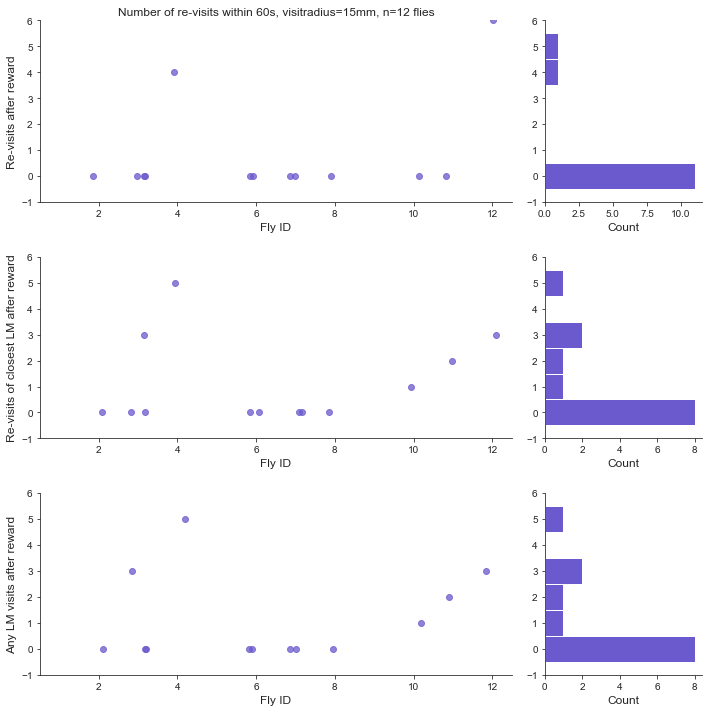

In [558]:
revisitsPerFly, axs = plt.subplots(3,2,figsize=(10,10), gridspec_kw={'width_ratios':[3,1]})
binrange = (0,6)
axs[0,0].set_title('Number of re-visits within {}s, visitradius={}mm, n={} flies'.format(windowMax, visitRad, numFlies), fontsize=12)

axs[0,0].set_ylabel('Re-visits after reward', fontsize=12)
for fly in range(numFlies):
    visitsFly = visitCountAll[fly]
    for i in range(len(visitsFly)):
        axs[0,0].plot(1+fly-0.2+np.random.rand(1)/2.5, visitsFly[i],'o', color=condCol[0],alpha=0.75)
axs[0,1].hist(visitCountAllList, range=binrange, bins=binrange[1], color=condCol[0], orientation='horizontal', align='left')

axs[1,0].set_ylabel('Re-visits of closest LM after reward', fontsize=12)
for fly in range(numFlies):
    visitsFly = revisitLMCountAll[fly]
    for i in range(len(visitsFly)):
        axs[1,0].plot(1+fly-0.2+np.random.rand(1)/2.5, visitsFly[i],'o', color=condCol[0],alpha=0.75)
axs[1,1].hist(revisitLMCountAllList, range=binrange, bins=binrange[1], color=condCol[0], orientation='horizontal', align='left')

axs[2,0].set_ylabel('Any LM visits after reward', fontsize=12)
for fly in range(numFlies):
    visitsFly = visitLMCountAll[fly]
    for i in range(len(visitsFly)):
        axs[2,0].plot(1+fly-0.2+np.random.rand(1)/2.5, visitsFly[i],'o', color=condCol[0],alpha=0.75)
axs[2,1].hist(visitLMCountAllList, range=binrange, bins=binrange[1], color=condCol[0], orientation='horizontal', align='left')


for i in range(3):
    axs[i,0].set_xlim(0.5,numFlies+0.5)
    axs[i,0].set_ylim(-1,binrange[1])
    axs[i,0].set_xlabel('Fly ID', fontsize=12)
    axs[i,1].set_ylim(-1,binrange[1])
    axs[i,1].set_xlabel('Count', fontsize=12)

revisitsPerFly.tight_layout()
for ax in axs: [myAxisTheme(a) for a in ax]

revisitsPerFly.savefig(analysisDir + 'revisits/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
          +'_revisitsPostReward_'+str(windowMax)+'s_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))+selectionTag+'.pdf', format='pdf')

### Total number of landmark visits and distinct landmark visits

In [559]:
for visRad in [10,15]:
    visitLMCountAll = []

    for fly in range(numFlies):
        querystring = '(flyID == "'+flyIDs[fly]+'")'
        xtrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        ytrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        ttrial = FOAllFlies_df.query(querystring)['time'].values.squeeze()

        dist2obj = np.hypot(xtrial, ytrial)

        entries,exits,visitT,entryTime,exitTime = countvisits(dist2obj,ttrial,visRad)

        visitLMCountAll.append(sum(entries))

    np.save(analysisDir + 'revisits/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
            +'_totalNumberLMVisits_visitRad' +str(visRad)+'mm_n'+ str(len(flyIDs))+selectionTag, visitLMCountAll)

    numDifferentLM = []

    for fly in range(numFlies):
        querystring = '(flyID == "'+flyIDs[fly]+'")'
        xtrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        ytrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        xraw = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
        yraw = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
        ttrial = FOAllFlies_df.query(querystring)['time'].values.squeeze()

        dist2obj = np.hypot(xtrial, ytrial)

        entries,exits,visitT,entryTime,exitTime = countvisits(dist2obj,ttrial,visRad)

        visitLoc = zip(np.asarray(xraw[entries>0]),np.asarray(yraw[entries>0]))
        LMid = []
        # find closest object at event time
        for l, loc in enumerate(visitLoc):
            objCoord = np.nan*np.ones(2)
            for i, vc in enumerate(objcoord):
                # ...find points that are close and project them to the origin
                distToObj = np.hypot(loc[0]-vc[0], loc[1]-vc[1])
                if distToObj < 1.5*visRad:
                    objCoord = vc
                    LMid.append(i)
                    continue

        numDifferentLM.append(len(set(LMid)))

    np.save(analysisDir + 'revisits/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
            +'_totalNumber-Distinct-LMVisits_visitRad' +str(visRad)+'mm_n'+ str(len(flyIDs))+selectionTag, numDifferentLM)

### Total path length

In [560]:
totalPathLenght = []

for fly in range(numFlies):
    querystring = '(flyID == "'+flyIDs[fly]+'")'
    xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
    ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
    d = np.hypot(np.diff(xtrial), np.diff(ytrial))
    d[d>10] = 0
    
    totalPathLenght.append(sum(d))

np.save(analysisDir + 'revisits/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
        +'_totalPathlength_n'+ str(len(flyIDs))+selectionTag, totalPathLenght)

